In [16]:
import sys
import os
import pandas as pd
import numpy as np
import logging
import warnings
warnings.filterwarnings('ignore')

# Add the parent directory to the Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')



In [17]:
# Add the parent directory to the Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append("../")

In [18]:
from scripts.feature_engineering import create_aggregate_features,extract_transaction_features,encode_categorical_variables,handle_missing_values,scale_numerical_features

# Load the dataset
data = pd.read_csv('../data/data_eda.csv')

id_column = 'CustomerId'
amount_column = 'Amount'
datetime_column = 'TransactionStartTime'
categorical_columns = ['TransactionId',	'BatchId',	'AccountId',	'SubscriptionId',	'CustomerId',	'CurrencyCode',	'CountryCode',
                       	'ProviderId'	,'ProductId',	'ProductCategory',	'ChannelId']
numerical_columns = ['Amount']

    # Create Aggregate Features
aggregate_features = create_aggregate_features(data, id_column, amount_column)

    # Extract Features
data = extract_transaction_features(data, datetime_column)

    # Encode Categorical Variables
#data = encode_categorical_variables(data, categorical_columns)

    # Handle Missing Values
#data = handle_missing_values(data, strategy='mean')

    # Normalize/Standardize Numerical Features
data = scale_numerical_features(data, numerical_columns, method='standardize')
data.to_csv('../data/data_scaled.csv', index=False)
print("Feature Engineering tasks completed successfully!")


--- Creating Aggregate Features ---
Aggregate features created successfully!
--- Extracting Date and Time Features ---
Date and time features extracted successfully!
--- Scaling Numerical Features ---
Numerical features scaled using standardize method!
Feature Engineering tasks completed successfully!


# Task 04

--- Calculating RFMS Features ---
RFMS Features calculated successfully!
--- Visualizing RFMS Scores ---


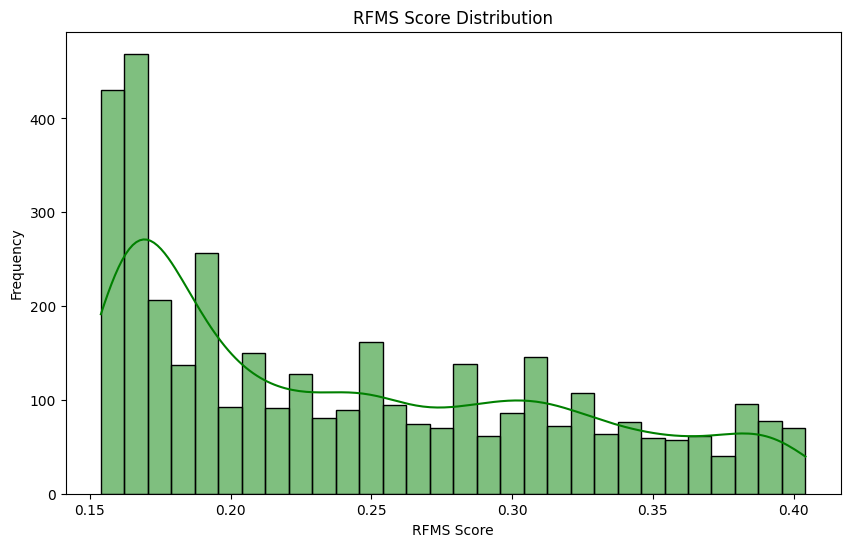

Boundary established at RFMS score: 0.22354249634088577
--- Assigning Good and Bad Labels ---
Labels assigned successfully!
--- Performing WoE Binning ---
WoE Binning completed successfully!
Default estimator and WoE binning tasks completed successfully!


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from datetime import datetime
# Task 1: RFMS Formalism (Recency, Frequency, Monetary, Seasonality)
def calculate_rfms(df, customer_id, recency_col, frequency_col, monetary_col):
    print("--- Calculating RFMS Features ---")
    # Calculate RFMS metrics
    rfms = df.groupby(customer_id).agg(
        recency=(recency_col, 'min'),
        frequency=(frequency_col, 'count'),
        monetary=(monetary_col, 'sum'),
       # seasonality=(seasonality_col, 'mean')
    ).reset_index()

    # Normalize RFMS metrics for scoring
    for col in ['recency', 'frequency', 'monetary']:
        rfms[col] = (rfms[col] - rfms[col].min()) / (rfms[col].max() - rfms[col].min())

    # Calculate RFMS score
    rfms['rfms_score'] = 0.25 * rfms['recency'] + 0.25 * rfms['frequency'] + 0.25 * rfms['monetary'] 
    print("RFMS Features calculated successfully!")
    return rfms

# Task 2: Visualize RFMS and Establish Boundary
def visualize_rfms_and_establish_boundary(rfms):
    print("--- Visualizing RFMS Scores ---")
    plt.figure(figsize=(10, 6))
    sns.histplot(rfms['rfms_score'], kde=True, bins=30, color='green')
    plt.title('RFMS Score Distribution')
    plt.xlabel('RFMS Score')
    plt.ylabel('Frequency')
    plt.show()

    # Establish boundary (e.g., using median as threshold)
    boundary = rfms['rfms_score'].median()
    print(f"Boundary established at RFMS score: {boundary}")
    return boundary

# Task 3: Assign Good and Bad Labels
def assign_labels(rfms, boundary):
    print("--- Assigning Good and Bad Labels ---")
    rfms['label'] = np.where(rfms['rfms_score'] >= boundary, 'good', 'bad')
    print("Labels assigned successfully!")
    return rfms

# Task 4: Weight of Evidence (WoE) Binning
def woe_binning(df, feature, target):
    print("--- Performing WoE Binning ---")
    binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
    df[feature + '_bin'] = binner.fit_transform(df[[feature]])

    # Calculate WoE and IV
    woe_dict = {}
    for b in sorted(df[feature + '_bin'].unique()):
        total = len(df)
        good = len(df[(df[feature + '_bin'] == b) & (df[target] == 'good')])
        bad = len(df[(df[feature + '_bin'] == b) & (df[target] == 'bad')])

        good_dist = good / total
        bad_dist = bad / total

        woe = np.log((good_dist + 1e-6) / (bad_dist + 1e-6))
        woe_dict[b] = woe

    print("WoE Binning completed successfully!")
    return df, woe_dict


customer_id = 'CustomerId'
date_string = '2025-01-28'
datetime_object = datetime.strptime(date_string, "%Y-%m-%d")

data['recency_days'] = (datetime_object - data['TransactionStartTime']).dt.days
recency_col = 'recency_days'
frequency_col = 'TransactionId'
monetary_col = 'Amount'
#seasonality_col = 'seasonality_score'

# Calculate RFMS
rfms = calculate_rfms(data, customer_id, recency_col,frequency_col, monetary_col)

# Visualize and establish boundary
boundary = visualize_rfms_and_establish_boundary(rfms)

# Assign good and bad labels
rfms = assign_labels(rfms, boundary)

# Perform WoE Binning
target = 'label'
feature = 'rfms_score'
rfms, woe_dict = woe_binning(rfms, feature, target)

print("Default estimator and WoE binning tasks completed successfully!")


# Task 05: Modeling

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

# Load the scaled data
data = pd.read_csv("../data/data_scaled_2.csv")

# Assuming the last column is the target variable and others are features
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Hyperparameter tuning for Random Forest (example)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

print("\nPerforming Grid Search for Random Forest...")
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
best_rf = grid_search_rf.best_estimator_

# Evaluate the tuned Random Forest on the test set
y_pred_rf = best_rf.predict(X_test)
print("\nTuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))



Training Logistic Regression...
Logistic Regression Classification Report:
              precision    recall  f1-score   support

        2018       1.00      1.00      1.00      9647
        2019       1.00      1.00      1.00      9486

    accuracy                           1.00     19133
   macro avg       1.00      1.00      1.00     19133
weighted avg       1.00      1.00      1.00     19133


Training Decision Tree...
Decision Tree Classification Report:
              precision    recall  f1-score   support

        2018       1.00      1.00      1.00      9647
        2019       1.00      1.00      1.00      9486

    accuracy                           1.00     19133
   macro avg       1.00      1.00      1.00     19133
weighted avg       1.00      1.00      1.00     19133


Training Random Forest...
Random Forest Classification Report:
              precision    recall  f1-score   support

        2018       1.00      1.00      1.00      9647
        2019       1.00      1.00